<a href="https://colab.research.google.com/github/Blacknahil/Icog-tasks/blob/main/qpfs/qpfs_for_iris_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Load and preproccess the data

### imports

In [2]:
from sklearn.datasets import load_iris

In [4]:
import pandas as pd

In [8]:
from sklearn.feature_selection import mutual_info_classif

In [10]:
import numpy as np

Loading iris

In [3]:
iris= load_iris()

In [6]:
X = pd.DataFrame(iris.data, columns=iris.feature_names)  # Feature matrix
y = iris.target  # Target labels (flower species)

In [9]:
# print(X.head())
# print(y)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


## 2. Compute feature relevance (F) using Mutual information

Lets calculate the mutual information(MI) between each feature and the class labels.

In [11]:
F=mutual_info_classif(X,y)
F= F/np.max(F) # Normalize the mutual information to be in the range [0,1]

In [14]:
print(F)

[0.48725033 0.31635032 1.         0.98598746]


print the feature relevance scores

In [13]:
## print the feature relevance scores
for i in range(len(iris.feature_names)):
    print(f"{iris.feature_names[i]}: {F[i]}")

sepal length (cm): 0.48725032679379954
sepal width (cm): 0.31635032037825034
petal length (cm): 1.0
petal width (cm): 0.985987455666715


Computes how well each feature predicts the target class.
Higher F values mean more relevant features.

## 3. Computer the feature similarity/ redundancy Using Pearson Correlation

Lets create a 4*4 similarity matrix Q using Pearson Correlation

In [19]:
from scipy.stats import pearsonr

In [27]:
num_featues= X.shape[1]
# print(num_featues)
Q= np.zeros((num_featues,num_featues))
# print(Q)


for i in range(num_featues):
  for j in range(num_featues):
    Q[i, j], other_x = pearsonr(X.iloc[:, i], X.iloc[:, j])
    print(iris.feature_names[i],iris.feature_names[j],Q[i,j])
    # print("other_x",other_x)
    print("\n")

# Take the absolute values to measure similarity

sepal length (cm) sepal length (cm) 1.0


sepal length (cm) sepal width (cm) -0.11756978413300206


sepal length (cm) petal length (cm) 0.8717537758865831


sepal length (cm) petal width (cm) 0.8179411262715756


sepal width (cm) sepal length (cm) -0.11756978413300206


sepal width (cm) sepal width (cm) 0.9999999999999999


sepal width (cm) petal length (cm) -0.4284401043305397


sepal width (cm) petal width (cm) -0.36612593253643905


petal length (cm) sepal length (cm) 0.8717537758865831


petal length (cm) sepal width (cm) -0.4284401043305397


petal length (cm) petal length (cm) 0.9999999999999997


petal length (cm) petal width (cm) 0.962865431402796


petal width (cm) sepal length (cm) 0.8179411262715756


petal width (cm) sepal width (cm) -0.36612593253643905


petal width (cm) petal length (cm) 0.962865431402796


petal width (cm) petal width (cm) 1.0




In [25]:
# Take the absolute value to measure similarity
Q= np.abs(Q)

In [26]:
print("Feature Similarity Matrix(Q):")
print(Q)

Feature Similarity Matrix(Q):
[[1.         0.11756978 0.87175378 0.81794113]
 [0.11756978 1.         0.4284401  0.36612593]
 [0.87175378 0.4284401  1.         0.96286543]
 [0.81794113 0.36612593 0.96286543 1.        ]]


Measure how redundant features/columns are to each other. Higher Qij values mean more redundancy

## 4. Formulate and solve the quadratic programming(QP) Problem

we solve the optimization problem $$ \min_x \frac{1}{2} (1 - \alpha) x^T Q x - \alpha F^T x $$

with constraints:
$$ x \geq 0 $$
$$ \sum x =1 $$




In [67]:
# Define alpha (trade-off between relevance and redundancy)
alpha = 0.8


TO solve the optimization problem stated above we use a python library.
CVXOPT is a Python library for convex optimization that is used to solve Quadratic Programming (QP) problems. However, CVXOPT requires a specific matrix format to work properly.



In [30]:
from cvxopt import matrix,solvers

In [68]:
## covert to CVXOPT format
P= matrix((1-alpha) * Q)
# quadratic term: redundancy between features

q= matrix(-alpha * F)
# linear term:
# repreasenting the contribution of each feature to the class label (0,1,2)
num_features = X.shape[1]
G = matrix(-np.eye(num_features)) # constraint x>=0

h=matrix(np.zeros(num_features))
A =matrix(np.ones((1,num_features))) # sum(x)=1 constraint
b= matrix(1.0)


solve the QP problem using the solver imorted from cvxopt

In [69]:
solvers.options["show_progress"]=True
solution = solvers.qp(P,q,G,h,A,b)

     pcost       dcost       gap    pres   dres
 0: -6.5054e-01 -1.7055e+00  1e+00  2e-16  2e+00
 1: -6.6873e-01 -7.1341e-01  4e-02  2e-16  1e-01
 2: -6.9683e-01 -7.0055e-01  4e-03  2e-16  3e-03
 3: -6.9978e-01 -7.0004e-01  3e-04  7e-18  1e-16
 4: -6.9999e-01 -7.0000e-01  8e-06  3e-16  2e-16
 5: -7.0000e-01 -7.0000e-01  8e-08  1e-16  1e-16
Optimal solution found.


In [62]:
print(solution)

{'x': <4x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <4x1 matrix, tc='d'>, 'z': <4x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 6.482608557046123e-07, 'relative gap': 6.482610861052647e-07, 'primal objective': -0.9999996445866375, 'dual objective': -1.0000002928474938, 'primal infeasibility': 6.661338147750939e-16, 'dual infeasibility': 1.2155339233861025e-16, 'primal slack': 1.803081376610369e-07, 'dual slack': 2.928474939275236e-07, 'iterations': 5}


In [70]:
## extract feature importance scores
x = np.array(solution["x"]).flatten()

In [71]:
# Print feature importance scores
print("Feature Importance Scores:", x)
print()

for i in range(len(iris.feature_names)):
    print(f"{iris.feature_names[i]}: {x[i]}")

Feature Importance Scores: [5.74557410e-09 9.74262067e-09 9.99981396e-01 1.85882345e-05]

sepal length (cm): 5.7455741014591355e-09
sepal width (cm): 9.742620672842641e-09
petal length (cm): 0.9999813962773226
petal width (cm): 1.858823448249304e-05


## 5. Visualize the feature importance scores and selected features

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

<ipython-input-72-0a2154deeeea>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=iris.feature_names, y=x, palette="viridis")


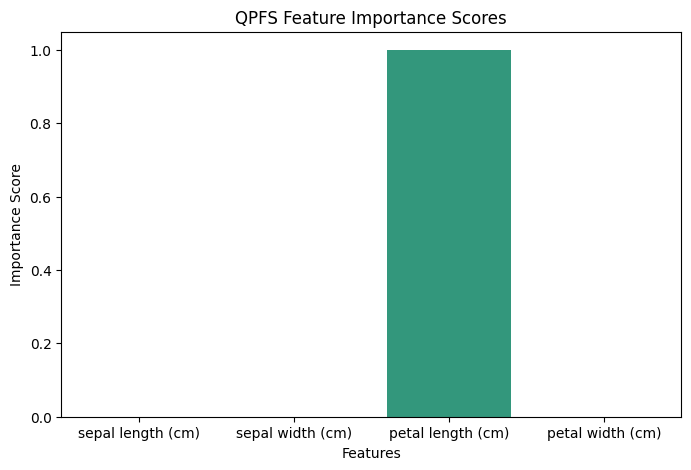

In [72]:
# Visualize feature importance
plt.figure(figsize=(8,5))
sns.barplot(x=iris.feature_names, y=x, palette="viridis")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.title("QPFS Feature Importance Scores")
plt.show()
